Starting training with Kernel Regression and Automated Gamma Selection...
Iter 0001 │ Policy Loss: 0.00466 │ Kernel MSE: 0.000370 │ Best Gamma: 1.000 │ Δ=0.06136 │ L2=0.01324
Iter 0100 │ Policy Loss: 0.00445 │ Kernel MSE: 0.000357 │ Best Gamma: 10.000 │ Δ=0.05605 │ L2=0.01284
Iter 0200 │ Policy Loss: 0.00435 │ Kernel MSE: 0.000278 │ Best Gamma: 1.000 │ Δ=0.06142 │ L2=0.00982
Iter 0300 │ Policy Loss: 0.00375 │ Kernel MSE: 0.000233 │ Best Gamma: 1.000 │ Δ=0.04795 │ L2=0.00953
Iter 0400 │ Policy Loss: 0.00358 │ Kernel MSE: 0.000190 │ Best Gamma: 1.000 │ Δ=0.02576 │ L2=0.00773
Iter 0500 │ Policy Loss: 0.00271 │ Kernel MSE: 0.000141 │ Best Gamma: 1.000 │ Δ=0.03018 │ L2=0.00713
Iter 0600 │ Policy Loss: 0.00289 │ Kernel MSE: 0.000112 │ Best Gamma: 1.000 │ Δ=0.03418 │ L2=0.00669
Iter 0700 │ Policy Loss: 0.00221 │ Kernel MSE: 0.000070 │ Best Gamma: 1.000 │ Δ=0.02465 │ L2=0.00540
Iter 0800 │ Policy Loss: 0.00161 │ Kernel MSE: 0.000047 │ Best Gamma: 1.000 │ Δ=0.01510 │ L2=0.00399
Iter 0900 │ Poli

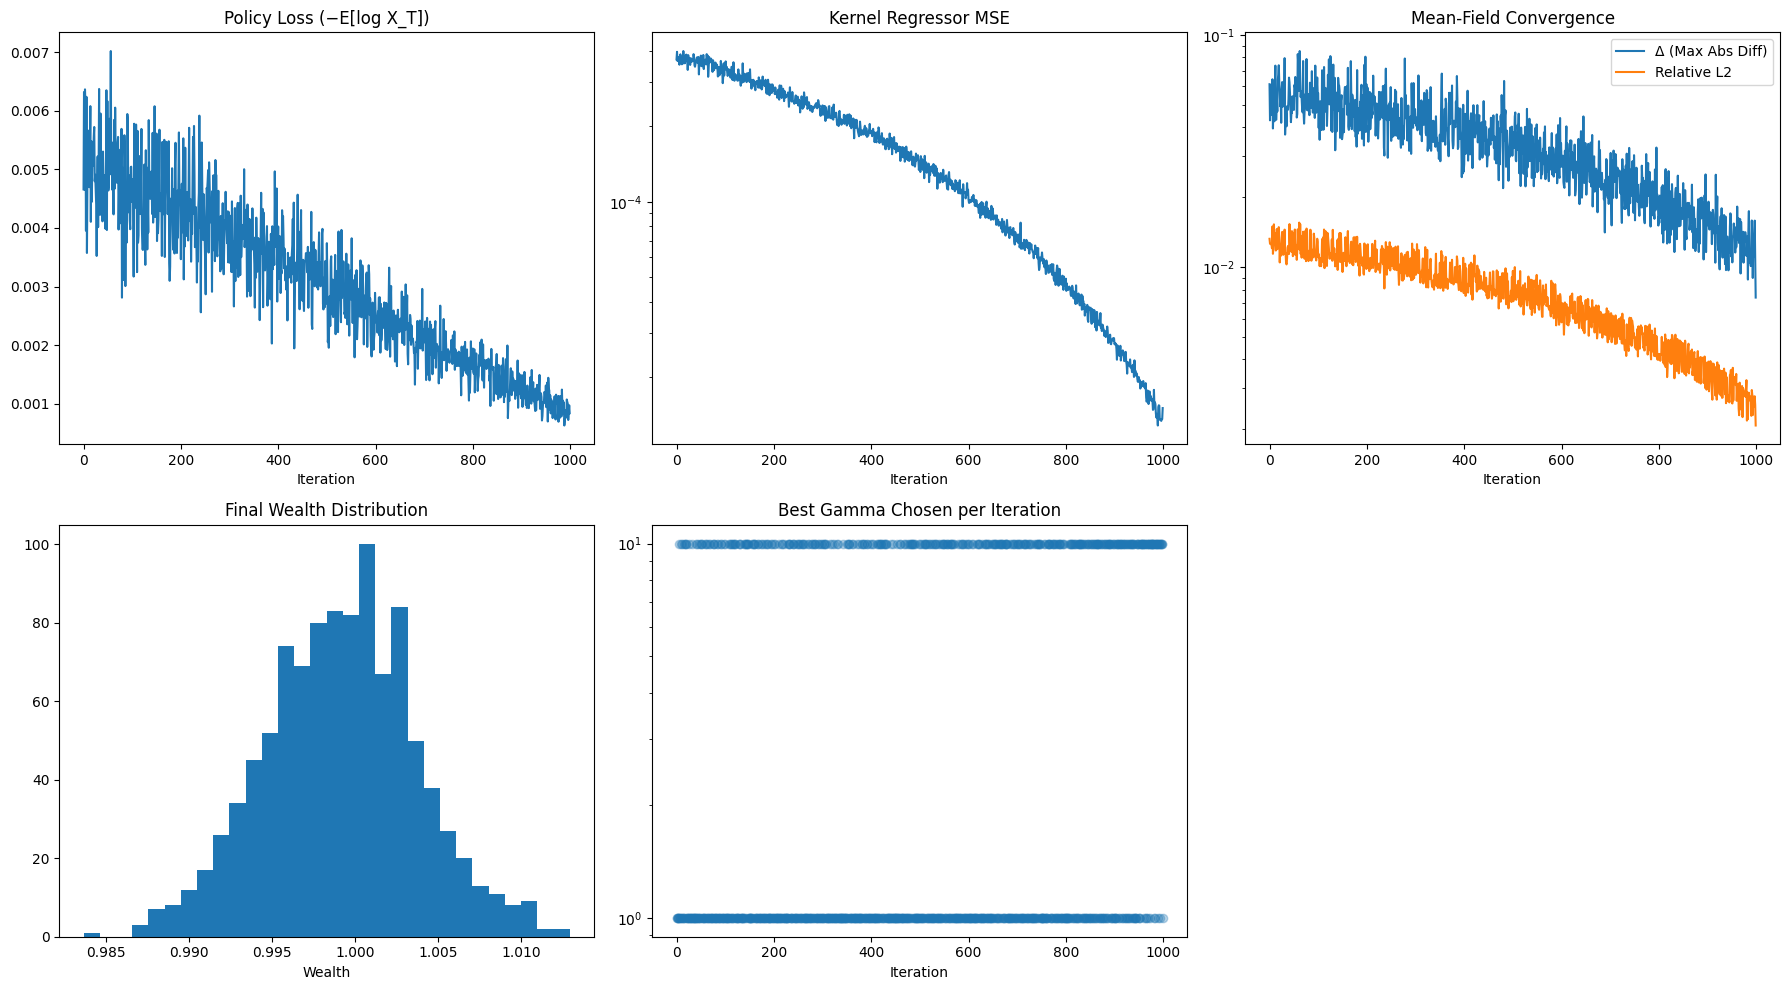

In [3]:
import numpy as np
import torch
import torch.nn as nn # <-- This line was missing
import signatory
import matplotlib.pyplot as plt

# === Hyper-parameters ===
T, K = 1.0, 100
dt      = T/K
N       = 1024
M       = 2
mu, nu, sigma = 0.05, 0.2, 0.15
X0      = 1.0
ROUNDS  = 1000

POLICY_LR    = 5e-6
MF_ALPHA     = 0.05

# Define a search space for the kernel bandwidth gamma
# We will automatically select the best gamma from this list in each iteration
GAMMA_CANDIDATES = [0.001, 0.01, 0.1, 1.0, 10.0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Time grid
time_grid = torch.linspace(0, T, K+1).unsqueeze(0).unsqueeze(2).repeat(N,1,1).to(device)

def utility(x):
    return torch.log(x + 1e-8)

def rel_L2(curr, prev, dt):
    num = np.mean(np.sum((curr - prev)**2, axis=1) * dt)
    den = np.mean(np.sum(prev**2, axis=1) * dt)
    return np.sqrt(num / (den + 1e-9))

# ── Policy network ────────────────────────────────
def make_policy():
    return nn.Sequential(
        nn.Linear(3, 32), nn.ReLU(),
        nn.Linear(32, 32), nn.ReLU(),
        nn.Linear(32, 32), nn.ReLU(),
        nn.Linear(32, 1)
    ).to(device)

# ── Kernel Regressor with Automated Gamma Selection ──
def kernel_regressor(query_sigs, key_sigs, values, gamma_candidates):
    # This function performs RBF Kernel Regression and finds the best gamma.
    sigs_norm_sq = torch.sum(query_sigs**2, dim=1, keepdim=True)
    dists_sq = sigs_norm_sq - 2 * torch.matmul(query_sigs, key_sigs.T) + sigs_norm_sq.T

    best_gamma = -1
    min_mse = float('inf')
    final_preds = None

    # Find the best gamma by minimizing leave-one-out cross-validation error (approximated by MSE on the batch)
    for gamma in gamma_candidates:
        weights = torch.exp(-gamma * dists_sq)
        weights.fill_diagonal_(0)
        
        norm_factor = torch.sum(weights, dim=1, keepdim=True)
        norm_factor[norm_factor == 0] = 1 # Avoid division by zero
        norm_weights = weights / norm_factor
        
        preds = torch.matmul(norm_weights, values)
        mse = nn.MSELoss()(preds, values)
        
        if mse.item() < min_mse:
            min_mse = mse.item()
            best_gamma = gamma
            final_preds = preds
            
    return final_preds, best_gamma, min_mse
    
# ── One forward simulation ────────────────────────
def simulate(policy, mean_field, dW, dB):
    B = torch.cumsum(dB, dim=1)
    path = torch.cat([time_grid[:, :-1], B], dim=2)
    sig = signatory.signature(path, depth=M)
    
    X = torch.zeros(N, K+1, 1, device=device)
    X[:, 0, 0] = X0
    
    for k in range(K):
        t = time_grid[:, k]; x = X[:, k]; m = mean_field[:, k]
        pi = policy(torch.cat([t, x, m], 1))
        dX = pi * (mu * dt + nu * dW[:, k] + sigma * dB[:, k])
        X[:, k+1] = x + dX
        
    return X, sig

# ── Build models & optimizers ─────────────────────
policy = make_policy()
optP   = torch.optim.Adam(policy.parameters(), lr=POLICY_LR)

# ── Initialize mean field, histories ─────────────
mf = torch.full((N, K+1, 1), X0, device=device)
histP, histMSE, histD, histL2, histGamma = [], [], [], [], []

print("Starting training with Kernel Regression and Automated Gamma Selection...")
for it in range(1, ROUNDS+1):
    dW = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    dB = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    old_mean = mf.detach().cpu().squeeze(-1).numpy()

    # ── Kernel Regression Step ───────────────────────
    with torch.no_grad():
        X1, sig1 = simulate(policy, mf, dW, dB)
        X1_T = X1[:, -1] # Target final wealth, shape [N, 1]
    
        preds, best_gamma, min_mse = kernel_regressor(
            query_sigs=sig1, 
            key_sigs=sig1, 
            values=X1_T,
            gamma_candidates=GAMMA_CANDIDATES
        )

    # ── Update mean field (with stabilization) ──────
    new_mean_detached = preds.view(N, 1, 1).expand(-1, K + 1, -1)
    
    Δ = (mf - new_mean_detached).abs().max().item()
    cur = new_mean_detached.cpu().squeeze(-1).numpy()
    L2 = rel_L2(cur, old_mean, dt)

    mf = (1 - MF_ALPHA) * mf + MF_ALPHA * new_mean_detached

    # ── Policy training ─────────────────────────────
    X2, _ = simulate(policy, mf, dW, dB)
    X2_T = X2[:, -1, 0]
    
    lossP = -utility(X2_T).mean()
    optP.zero_grad()
    lossP.backward()
    optP.step()

    # ── Logging ─────────────────────────────────────
    histP.append(lossP.item())
    histMSE.append(min_mse)
    histD.append(Δ)
    histL2.append(L2)
    histGamma.append(best_gamma)
    
    if it % 100 == 0 or it == 1:
      print(f"Iter {it:04d} │ Policy Loss: {lossP:.5f} │ Kernel MSE: {min_mse:.6f} │ Best Gamma: {best_gamma:.3f} │ Δ={Δ:.5f} │ L2={L2:.5f}")

print("Training finished.")
# ── Final visualization ───────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

axes[0].plot(histP)
axes[0].set_title("Policy Loss (−E[log X_T])")
axes[0].set_xlabel("Iteration")

axes[1].plot(histMSE)
axes[1].set_title("Kernel Regressor MSE")
axes[1].set_xlabel("Iteration")
axes[1].set_yscale("log")

axes[2].plot(histD, label='Δ (Max Abs Diff)')
axes[2].plot(histL2, label='Relative L2')
axes[2].legend()
axes[2].set_title("Mean-Field Convergence")
axes[2].set_xlabel("Iteration")
axes[2].set_yscale("log")

axes[3].hist(X2[:, -1, 0].detach().cpu().numpy(), bins=30, density=True)
axes[3].set_title("Final Wealth Distribution")
axes[3].set_xlabel("Wealth")

axes[4].plot(histGamma, 'o', alpha=0.3)
axes[4].set_title("Best Gamma Chosen per Iteration")
axes[4].set_xlabel("Iteration")
axes[4].set_yscale("log")

fig.delaxes(axes[5]) # Remove empty subplot
plt.tight_layout()
plt.show()